# US Name

Data preparation combine table information and journals


# Description

None

## Merge

**Main table** 

papers_meta_analysis_new

Merged with:

- papers_meta_analysis
- journals_scimago

# Target

- The file is saved in S3:
- bucket: datalake-datascience
- path: DATA/FINANCE/ESG/ESG_CFP
- Glue data catalog should be updated
- database: esg
- Table prefix: meta_analysis_
- table name: meta_analysis_esg_cfp
- Analytics
- HTML: ANALYTICS/HTML_OUTPUT/meta_analysis_esg_cfp
- Notebook: ANALYTICS/OUTPUT/meta_analysis_esg_cfp

# Metadata

- Key: 234_esg_metadata
- Epic: Dataset transformation
- US: Prepare meta-analysis table
- Task tag: #journal-information, #papers-information
- Analytics reports: https://htmlpreview.github.io/?https://github.com/thomaspernet/esg_metadata/blob/master/00_data_catalog/HTML_ANALYSIS/META_ANALYSIS_ESG_CFP.html

# Input

## Table/file

**Name**

- papers_meta_analysis_new
- papers_meta_analysis
- journals_scimago

**Github**

- https://github.com/thomaspernet/esg_metadata/blob/master/01_data_preprocessing/01_transform_tables/00_meta_analysis.md

In [ ]:
from awsPy.aws_authorization import aws_connector
from awsPy.aws_s3 import service_s3
from awsPy.aws_glue import service_glue
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import os, shutil, json, re

from GoogleDrivePy.google_drive import connect_drive
from GoogleDrivePy.google_platform import connect_cloud_platform
from GoogleDrivePy.google_authorization import authorization_service

path = os.getcwd()
parent_path = str(Path(path).parent.parent)


name_credential = 'financial_dep_SO2_accessKeys.csv'
region = 'eu-west-2'
bucket = 'datalake-london'
path_cred = "{0}/creds/{1}".format(parent_path, name_credential)

In [ ]:
con = aws_connector.aws_instantiate(credential = path_cred,
                                       region = region)
client= con.client_boto()
s3 = service_s3.connect_S3(client = client,
                      bucket = bucket, verbose = True) 
glue = service_glue.connect_glue(client = client) 

In [ ]:
try:
    os.mkdir("creds")
except:
    pass

s3.download_file(key = "CREDS/Financial_dependency_pollution/creds/token.pickle", path_local = "creds")
s3.download_file(key = "CREDS/Financial_dependency_pollution/creds/service.json", path_local = "creds")

auth = authorization_service.get_authorization(
    path_credential_gcp=os.path.join(path, "creds", "service.json"),
    path_credential_drive=os.path.join(path, "creds"),
    verbose=False,
    scope=['https://www.googleapis.com/auth/spreadsheets.readonly',
           "https://www.googleapis.com/auth/drive"]
)
gd_auth = auth.authorization_drive(path_secret=os.path.join(
    path, "creds", "credentials.json"))
service_account = auth.authorization_gcp()
drive = connect_drive.drive_operations(gd_auth)


shutil.rmtree(os.path.join(path,"creds"))

In [ ]:
pandas_setting = True
if pandas_setting:
    cm = sns.light_palette("green", as_cmap=True)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_colwidth', None)

# Author information

During a presentation (Desir Seminar), it has been pointed out that characteristic of an author might impact the desire results. Most of the information are available from the internet. 

We use two sources of information:

- [Semantic scholar](https://www.semanticscholar.org/me/research)
    - API: https://www.semanticscholar.org/product/api

Using both data sourcs, we will retrieve or compute the following information:

- author information (name, affiliation, publication, email, etc) -> From the API 
- author gender: From a model
- author expertise in ESG: Computed 

The workflow works in three steps:

1. Train gender detection model using US name from the public dataset [USA Names](https://console.cloud.google.com/marketplace/product/social-security-administration/us-names?project=lofty-foundry-302615)
2. Download paper and author information from the spreadsheet [CSR Excel File Meta-Analysis - Version 4 - 01.02.2021](https://docs.google.com/spreadsheets/d/11A3l50yfiGxxRuyV-f3WV9Z-4DcsQLYW6XBl4a7U4bQ/edit?usp=sharing)
3. Fusion paper and author informations. The final table has the size of number of papers x number of authors per paper. 

## Train deep learning model gender detection

The first step of the workflow consists to train a basic LSTM architecture to deter the gender from family name. 

Training the model requires the following steps:

1. Download the data from Google Cloud Platform
2. Lowercase first name, split character and convert them to numerical value
3. Train the model using a vector embedding, Bidirectional LSTM layer and a dense layer to compute the prediction 

### Download data

The data comes from the public dataset [USA Names](https://console.cloud.google.com/marketplace/product/social-security-administration/us-names?project=lofty-foundry-302615)

In [ ]:
project = 'valid-pagoda-132423'
gcp = connect_cloud_platform.connect_console(project = project,
                                             service_account = service_account,
                                             colab = False)

sql = """
SELECT
  name,
  gender,
  COUNT(name) AS num_names
FROM
  `bigquery-public-data.usa_names.usa_1910_current`
GROUP BY
  name,
  gender
"""

#names_df = client.query(sql).to_dataframe()
names_df = gcp.upload_data_from_bigquery(query = sql,location = "US")

In [ ]:
names_df.shape

In [ ]:
names_df.head()

### Clean up and pre-process

1. Clean up name ->Lowercase the name.
2. Get a list of characters from the name.
3. Create a padding: each name as a length of 50 characters max. The padding fills the empty values with 0 to reach 50.
4. Encode characters and gender as specify in Keras. Note, the character 'space' is encoded as 0

For example, the preprocessing step does the following:

Take the name  "mary", the character "m" is given the number 13, the character "a" is 1, and so one. The 0s are the padding because the matrix should have the same dimension

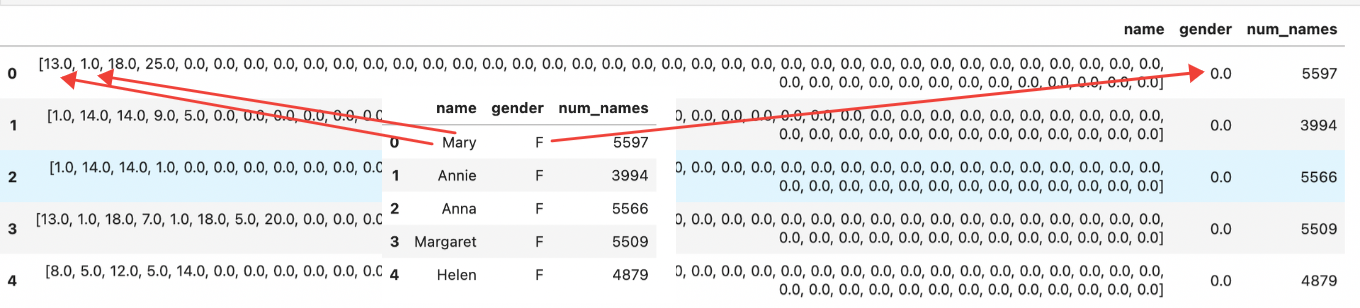

In [ ]:
def preprocess(names_df,column, train=True, to_lower = True):
    # Step 1: Lowercase
    if to_lower:
        names_df['name'] = names_df[column].str.lower()
    else:
        names_df['name'] = names_df[column]
    # Step 2: Split individual characters
    names_df['name'] = [list(name) for name in names_df['name']]

    # Step 3: Pad names with spaces to make all names same length
    name_length = 50
    names_df['name'] = [
        (name + [' ']*name_length)[:name_length] 
        for name in names_df['name']
    ]

    # Step 4: Encode Characters to Numbers
    names_df['name'] = [
        [
            max(0.0, ord(char)-96.0) 
            for char in name
        ]
        for name in names_df['name']
    ]
    
    if train:
        # Step 5: Encode Gender to Numbers
        names_df['gender'] = [
            0.0 if gender=='F' else 1.0 
            for gender in names_df['gender']
        ]
        return names_df
    else:
        return names_df['name']

In [ ]:
names_df = preprocess(names_df, column = 'name', train=True)
names_df.head()

### Model Architecture

1. Embedding layer: to “embed” each input character’s encoded number into a dense 256 dimension vector..
2. Bidirectional LSTM layer: .
3. Final Dense layer: Prediction 0/1 for male/female

Note: Embedding layer enables us to convert each word into a fixed length vector of defined size. The resultant vector is a dense one with having real values instead of just 0’s and 1’s. The fixed length of word vectors helps us to represent words in a better way along with reduced dimensions

In [ ]:
#!pip install --upgrade tensorflow

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.optimizers import Adam

def lstm_model(num_alphabets=27, name_length=50, embedding_dim=256):
    model = Sequential([
        Embedding(num_alphabets, embedding_dim, input_length=name_length),
        Bidirectional(LSTM(units=128, recurrent_dropout=0.2, dropout=0.2)),
        Dense(1, activation="sigmoid")
    ])

    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=0.001),
                  metrics=['accuracy'])

    return model

The idea is to turns positive integers (indexes) into dense vectors of fixed size. Then this layer can be used as the first layer in a model.

The size of the vocabulary (the list from the preprocessing) is equal to 27: The alphabet has 26 letters, and the space characters. We want the output layer to be a vector of 256 weights. `input_length` is the maximum size of the name. We can set it up since the length of input sequences is constant.

Here is an example of how the vector embedding output looks like

Note: In this example we have not trained the embedding layer. The weights assigned to the word vectors are initialized randomly.

In [ ]:
model_ex = Sequential()
model_ex.add(Embedding(input_dim= 27, output_dim= 256, input_length=50))
model_ex.compile(loss = 'binary_crossentropy', metrics= 'accuracy')
output_array = model_ex.predict(names_df['name'].values.tolist())

In [ ]:
output_array.shape

The embedding vector for the first word is:

In [ ]:
output_array[0].shape

In [ ]:
output_array[0]

### Training the Model

We’ll use the standard tensorflow.keras training pipeline

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
%time

# Step 1: Instantiate the model
model = lstm_model(num_alphabets=27, name_length=50, embedding_dim=256)

# Step 2: Split Training and Test Data
X = np.asarray(names_df['name'].values.tolist())
y = np.asarray(names_df['gender'].values.tolist())

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=0)

# Step 3: Train the model
callbacks = [
    EarlyStopping(monitor='val_accuracy',
                  min_delta=1e-3,
                  patience=5,
                  mode='max',
                  restore_best_weights=True,
                  verbose=1),
]

history = model.fit(x=X_train,
                    y=y_train,
                    batch_size=64,
                    epochs=50,
                    validation_data=(X_test, y_test),
                    callbacks=callbacks)

# Step 4: Save the model
model.save('MODELS_AND_DATA/boyorgirl.h5')

In [ ]:
# Step 5: Plot accuracies
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Semantic scolar

Our primary objective is to get the information about gender, evaluate the expertise of an author about ESG but also derive meaningful information from the abstract. The data source [Semantic Scholar](https://www.semanticscholar.org/me/research) has 198,182,311 papers from all fields of science.

Our strategy is to use the API to search for a paper in order to get the related information (DOI, cite, performance) and more importantly, the ID of the author(s). Indeed, to get information about an author, we need to know his/her ID. As soon as we have the ID, we can collect and compute all other information (i.e. gender and expertise)

The workflow is the following:

1. Download data and predict gender
2. Flag ESG papers
3. Compute sentiment and cluster papers using the abstract
4. Compute ESG expertise score
5. Combine all information

![](https://cdn-images-1.medium.com/max/1600/1*rEcC_x1CRlWx1KRCySotIg.png)

In [ ]:
#from serpapi import GoogleSearch
from tqdm import tqdm
import time
import pickle
import re
from tensorflow.keras.models import load_model
import unicodedata
import requests

## 1. Download data and predict gender

We follow four steps approaches to get the paper and author information 

1. We fetch the data from the spreadsheet [CSR Excel File Meta-Analysis — Version 4–01.02.2021](https://docs.google.com/spreadsheets/d/11A3l50yfiGxxRuyV-f3WV9Z-4DcsQLYW6XBl4a7U4bQ/edit?usp=sharing) (note, I use the library [GoogleDrive-python](https://github.com/thomaspernet/GoogleDrive-python) to get the data from the spreadsheet). 
2. We pass the paper’s title into Semantic Scholar API to find the paper’s ID and use the ID to download the paper information (including the authors’ ID)
3. We pass the author’s ID into Semantic Scholar API to download the author’s information
4. We predict the gender from the first name of the author

![](https://cdn-images-1.medium.com/max/1600/1*jsBIqWumazLCekrlKbUg_A.png)

### Step 1: Download data from Google spreadsheet

The original data was collected on a Google spreadsheet ([CSR Excel File Meta-Analysis — Version 4–01.02.2021](https://docs.google.com/spreadsheets/d/11A3l50yfiGxxRuyV-f3WV9Z-4DcsQLYW6XBl4a7U4bQ/edit?usp=sharing)) with some relevant information but it also contains errors. The detection of errors has been done separately and won’t be covered in this post. From this spreadsheet, we will only use the title and the publication name. All the other information is discarded and will be retrieved using Semantic Scholar. 

In [ ]:
pred_model = load_model('MODELS_AND_DATA/boyorgirl.h5')

In [ ]:
#!pip install google-search-results

In [ ]:
FILENAME_SPREADSHEET = "CSR Excel File Meta-Analysis - Version 4 -  01.02.2021"
spreadsheet_id = drive.find_file_id(FILENAME_SPREADSHEET, to_print=False)
doi = drive.download_data_from_spreadsheet(
    sheetID = spreadsheet_id,
    sheetName = "Feuil1",
    to_dataframe = True)

In [ ]:
doi.loc[lambda x: x['Title'].isin(['The corporate social performance–financial performance link'])].head(1)

### Steps 2–3: paper information and author ID

In the second step, we want to use the unique title’s name from the spreadsheet to get the information we need (gender, abstract, publication year, etc). 

The previous image show one paper written by S. Waddock and S. Graves. We can look at the paper in [Semantic Scholar](https://www.semanticscholar.org/me/research)

- [The corporate social performance-financial performance](https://www.semanticscholar.org/paper/2e899bc9e49e4a55374f26fdfd3f777658d460ab)

![](https://cdn-images-1.medium.com/max/1600/1*RsOxfDRLtIu-_pUbmn--pw.png)

The DOI is “*10.1002/(SICI)1097–0266(199704)18:4<03::AID-SMJ869>3.0.CO;2-G*”

In [ ]:
headers = {
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'
}


In [ ]:
field = [
    "url",
    "title",
    "abstract",
    "venue",
    "year",
    "referenceCount",
    "citationCount",
    "influentialCitationCount",
    "isOpenAccess",
    "fieldsOfStudy",
    "authors"]
field_paper = [
    "externalIds",
    "url",
    "title",
    "abstract",
    "venue",
    "year",
    "referenceCount",
    "citationCount",
    "influentialCitationCount",
    "isOpenAccess",
    "fieldsOfStudy",
    "authors"
]
field_authors = [
    "externalIds",
    "url",
    "name",
    "aliases",
    "affiliations",
    "homepage",
    "papers"
]

In [ ]:
def find_doi(paper_name):
    """
    to keep thing simple, assume first results in the best option
    """
    paper_name_clean = (
        paper_name
        .lower()
        .replace("  ", "+")
        .replace(" ", "+")
        .replace("\n", "+")
        .replace(",", "+")
        .replace("–", "")
        .replace("++", "+")
        .replace(":", "")
    )
    url_paper = 'https://api.semanticscholar.org/graph/v1/paper/search?query={}&fields={}'.format(
        paper_name_clean, ",".join(field))
    response_1 = requests.get(url_paper, headers=headers)
    if response_1.status_code == 200:
        response_1 = response_1.json()
        if len(response_1['data']) > 0:
            url_paper = "https://api.semanticscholar.org/graph/v1/paper/{}?fields={}".format(
                response_1['data'][0]['paperId'], ",".join(field_paper))
            response_2 = requests.get(url_paper, headers=headers)
            if response_2.status_code == 200:
                # find publication name because not available in the API
                publication_name = (
                    doi
                    .loc[lambda x: x['Title'].isin([paper_name])]
                    .reindex(columns=['Publication name'])
                    .drop_duplicates()
                    .values[0][0]
                )
                # Find ID source spreadsheet
                id_source = (
                    doi
                    .loc[lambda x: x['Title'].isin([paper_name])]
                    .reindex(columns=['Nr. '])
                    .drop_duplicates()
                    .values[0][0]
                )
                response_2 = response_2.json()
                response_2['id_source'] = id_source
                response_2['paper_name_source'] = paper_name
                response_2['publication_name'] = publication_name
                response_2['status'] = 'found'

                # find authors details information
                authors_fulls = []
                for aut in response_1['data'][0]['authors']:
                    url_author = 'https://api.semanticscholar.org/graph/v1/author/{}?fields={}'.format(
                        aut['authorId'],
                        ",".join(field_authors))
                    response_3 = requests.get(url_author, headers=headers)
                    if response_3.status_code == 200:
                        authors_fulls.append(response_3.json())

                if len(authors_fulls) > 0:
                    response_2['authors_detail'] = authors_fulls

                return response_2
            else:
                return {'paper_name': paper_name, 'status': 'not found'}
        else:
            return {'paper_name': paper_name, 'status': 'not found'}
    else:
        return {'paper_name': paper_name, 'status': 'not found', 'status_code': response_1.status_code}

In [ ]:
def clean_name(name='Sarah'):
    """
    """
    
    return "".join(
        (
            c
            for c in unicodedata.normalize("NFD", name)
            if unicodedata.category(c) != "Mn"
        )
    ).lower().replace("-", ' ')
def prediction_gender(name=["sarah"]):
    """
    name should be normalised and a list of candidates
    """
    return np.mean(pred_model.predict(
        np.asarray(
            preprocess(
                pd.DataFrame(
                    name,
                    columns=['semantic_0']
                ), column="semantic_0", train=False
            )
            .values.tolist()
        )
    ))

To find the information from steps 2 to 3, we need to use 2 different [APIs](https://api.semanticscholar.org/graph/v1):

**Publication**

- To find the paper ID, we use https://api.semanticscholar.org/graph/v1/paper/search?query=

we construct the URL by cleaning the title, and we explicitly add the list of the fields to be returned:

https://api.semanticscholar.org/graph/v1/paper/search?query=the+corporate+social+performancefinancial+performance+link&fields=url,title,abstract,venue,year,referenceCount,citationCount,influentialCitationCount,isOpenAccess,fieldsOfStudy,authors

You can copy/paste the URL in your web browser to see all the information.

The response gives the paper ID:

```
{"paperId": "2e899bc9e49e4a55374f26fdfd3f777658d460ab", "url": "https://www.semanticscholar.org/paper/2e899bc9e49e4a55374f26fdfd3f777658d460ab", "title": "The corporate social performance-financial performance link"
```

but also, the authors( and ID)

```
"authors": [{"authorId": "66042905", "name": "S. Waddock"}, {"authorId": "2367938", "name": "S. Graves"}
```

Note that, we need an intermediary API call to get the DOI from the following URL https://api.semanticscholar.org/graph/v1/paper/2e899bc9e49e4a55374f26fdfd3f777658d460ab?fields=externalIds,url,title,abstract,venue,year,referenceCount,citationCount,influentialCitationCount,isOpenAccess,fieldsOfStudy,authors

**Authors**

- We use the following API to download the information of each author https://api.semanticscholar.org/graph/v1/author/66042905?fields=externalIds,url,name,aliases,affiliations,homepage,papers

The response provides two information we will use to compute the gender and the ESG score:

- *aliases*: all possible names of the author's
- *papers*: All papers from the authors. From the image below, we can see the author S. Waddock has 313 publications

![](https://cdn-images-1.medium.com/max/1600/1*caiIQivJ1fR2AJIPWxR_Jg.png)

https://www.semanticscholar.org/author/S.-Waddock/66042905?sort=influence

in the response, we store all of the 313 publications because we will use this information to compute the ESG expertise score.

```
[{'authorId': '66042905',
   'externalIds': {},
   'url': 'https://www.semanticscholar.org/author/66042905',
   'name': 'S. Waddock',
   'aliases': ['S Waddock',
    'Sandra Waddock',
    'Sandr A Waddock',
    'Sandra A. Waddock'],
   'affiliations': [],
   'homepage': None,
   'papers': [{'paperId': '39657170f4d0496f79d7c766e1911c48e5b8f25c',
     'title': 'The UN Guiding Principles on Business and Human Rights: Implications for Corporate Social Responsibility Research'}, ....]
```

In [ ]:
response = find_doi(paper_name = list(doi['Title'].unique())[-2]) 
response['externalIds']['DOI']

### Steps 4: Gender prediction

In the next step, we want to predict the gender of the author. The first author is *S. Waddock* which is impossible to detect the gender because only one letter displays for the first name. Therefore, we will combine the first name with all the aliases. We add another constraint, the first name should have more than 2 characters:

- ‘S. Waddock’: discarded
- ‘S Waddock’: discarded
- ‘Sandra Waddock’,
- ‘Sandr A Waddock’,
- ‘Sandra A. Waddock’

Then we push all the candidates to the model and return the average probability. The model gives an average probability of 43%, meaning the author is a female.

In [ ]:
prediction_gender(
    list(
                dict.fromkeys(
                    [clean_name(name=
                                re.sub(r"[^a-zA-Z0-9]+", ' ', a
                                      ).split(" ")[0]) for a in 
                     [response['authors_detail'][0]['name']] + response['authors_detail'][0]['aliases']
                     if len(a.split(" ")[0]) >2]
                )
            )
)

Get full list of information

In [ ]:
list_paper_semantic = []
list_failure = []

In [ ]:
for i, p in tqdm(enumerate(list(doi['Title'].unique()))):
    time.sleep(15)
    response = find_doi(paper_name = p)  
    if response['status'] == 'found':
        list_paper_semantic.append(response)
    else:
        list_failure.append(p)

In [ ]:
for i, authors in tqdm(enumerate(list_paper_semantic)):
    for author in authors["authors_detail"]:
        #### Clean authors
        author_clean = [clean_name(name=author["name"].split(" ")[0])] if \
                        len(clean_name(name=author["name"].split(" ")[0]))>2 else None
        if author["aliases"] is not None:
            author_clean_alias = list(
                dict.fromkeys(
                    [clean_name(name=
                                re.sub(r"[^a-zA-Z0-9]+", ' ', a
                                      ).split(" ")[0]) for a in author["aliases"] if len(a.split(" ")[0]) >2]
                )
            )
            if author_clean is not None:
                author_clean.extend(author_clean_alias)
            else:
                author_clean = author_clean_alias
        #### predict gender
        if len(author_clean) > 0:
            max_prediction = prediction_gender(name=author_clean)
            gender= "MALE" if max_prediction >=.5 else "FEMALE"
        else:
            max_prediction = None
            gender = 'UNKNOWN'
        author['gender'] = {'gender': gender, 'probability':max_prediction}

In [ ]:
list_failure

Failure: 

- 'The Effect of Corporate Social Responsibility on Financial Performance: Evidence from the Banking Industry in Emerging Economies',
- 'An examination of corporate social responsibility and financial performance: A study of the top 50 Indonesian listed corporations',
- 'Does it pay to be different? An analysis of the relationship between corporate social and financial performance (',
- 'Corporate Social and Environmental Performance and Their Relation to Financial Performance and Institutional Ownership: Empirical Evidence on Canadian Firms',
-  'The Corporate Social-Financial Performance Relationship: A Typology and Analysis'

In [ ]:
list_failure = ['The Effect of Corporate Social Responsibility on Financial Performance: Evidence from the Banking Industry in Emerging Economies',
 'An examination of corporate social responsibility and financial performance: A study of the top 50 Indonesian listed corporations',
 'Does it pay to be different? An analysis of the relationship between corporate social and financial performance (',
 'Corporate Social and Environmental Performance and Their Relation to Financial Performance and Institutional Ownership: Empirical Evidence on Canadian Firms',
 'The Corporate Social-Financial Performance Relationship: A Typology and Analysis']

In [ ]:
for ind, paper in enumerate(list_paper_semantic):
    with open("paper_id_{}".format(paper["paperId"]), "w") as outfile:
        json.dump(eval(str(paper)), outfile)
    s3.upload_file(
        file_to_upload="paper_id_{}".format(paper["paperId"]),
        destination_in_s3="DATA/JOURNALS/SEMANTIC_SCHOLAR/PAPERS",
    )
    os.remove("paper_id_{}".format(paper["paperId"]))

In [ ]:
# Store data (serialize)
with open('MODELS_AND_DATA/list_paper_semantic.pickle', 'wb') as handle:
    pickle.dump(list_paper_semantic, handle)

## 2. Flag ESG paper

The list of papers we saved in the previous steps contains 266 authors, with 14,443 unique publications. For each author, we want to evaluate how familiar he/she is with the topic of ESG. To flag an ESG publication (14.443), we rely on a naive technique.

The technique is the following:

- Create a clean list of words from the title (removing English stop words, special characters, and lower case)
- Flag if the clean list contains “esg”, ”environmental”, ”social”, ”governance”

The image below shows how we use the technique to flag the ESG paper. Take the title “*Corporate social responsibility and firm value: Guiding through
economic policy uncertainty*”, after the cleaning process, we end up with the following list of keywords “[corporate, social, responsibility, firm, value, guiding, economic, policy, uncertainty]”. Since the list contains the word “social”, we flag it as an ESG topic. By analogy, the title “*Does financial development really spur nascent entrepreneurship in Europe? A panel data analysis*” does not contain any of the ESG keywords

In total, 2094 papers deal with ESG among the 14,443 papers (14%). We will use this information later to construct the ESG expertise score.

In [ ]:
list_paper_semantic = pickle.load( open( "MODELS_AND_DATA/list_paper_semantic.pickle", "rb" ))

In [ ]:
from gensim.models import Word2Vec
import nltk
from nltk.corpus import stopwords
from scipy.spatial import distance
import string
#nltk.download('stopwords')
stop = stopwords.words('english')

In [ ]:
def basic_clean(text):
    return re.sub(r'[^\w\s]|[|]', '', text).split()

def dumb_search(items):
    #return any(item in 'esg environmental social governance' for item in items)
    return True if len([i for i in ['esg',"environmental","social","governance"] if i in items]) > 0 else False

In [ ]:
list_papers = []
null = [list_papers.extend(i) for i in pd.json_normalize(list_paper_semantic, "authors_detail")['papers'].to_list()]
all_connected_paper = (
    pd.DataFrame(list_papers)
    .drop_duplicates()
    .assign(
        name_clean=lambda x:
        x.apply(lambda x:
                basic_clean(' '.join([word.lower() for word in x['title'].split() if word not in (stop)])), axis=1)
    )
    .assign(
        esg = lambda x: x.apply(
            lambda x:
            dumb_search(x['name_clean']), axis = 1)
    )
)
all_connected_paper.shape

In [ ]:
all_connected_paper.head()

In [ ]:
all_connected_paper['esg'].value_counts(normalize = True)

In [ ]:
all_connected_paper['esg'].value_counts(normalize = False)

## 3. Sentiment and cluster papers

The last batch of information relates to the pertinence and details of the abstract. We might think that the abstract contains information about the “quality” or “emotion” behind the paper. Therefore, we propose to compute the following variables:

- **sentiment**: positive or negative. The overall feeling of the abstract. Positive means the abstract tend to have more words associated with a positive connotation.
- **cluster**: 3 clusters computed using the words in the abstract (embeddings), the number of verbs, nouns, and adjectives but also the size of the abstract.

### Construct sentiment

We use the brilliant [Flair](https://github.com/flairNLP/flair) library to compute the sentiment for different reasons. First of all, we don’t have labels in the abstract, hence we cannot train our own model. Second, Flair uses state-of-the-art NLP architecture to train their model, meaning that it gives far better results than if we had to build our model. 

The workflow to get the sentiment is the following

- Step 1: Clean the abstract:
   — Lowercase words
   — Remove [+XYZ chars] in content
   — Remove multiple spaces in content
   — Remove ellipsis (and last word)
   — Replace dash between words
   — Remove punctuation
   — Remove stopwords
   — Remove digits
   — Remove short tokens
- Step 2: Compute the sentiments using the [Flair](https://github.com/flairNLP/flair) library

Among the 106 papers we have, 71 have a positive sentiment derived from the abstract and 35 negative ones.

### Clustering

The abstract contains relevant information about the quality of the papers, and we want to extract them to group the papers into 3 clusters. To construct the cluster, we use the vector word embedding from “*word2vec-google-news-300”*. We don’t have enough data to train our model, and Google has already done the heavy lifting so it sounds more reasonable to use pre-computed vectors. We also include the number of ESG occurrences in the abstract, number of adjectives, nouns, and verbs. It seems plausible that the “quality” of the abstract is correlated with the number of verbs or adjectives since they give more emotion to the reader.

- Step 1: Count the number of adjectives, nouns, and verbs
- Step 2: Get the vector’s embedding from the pre-trained model `word2vec-google-news-300` and look up each word in the list. Compute the average to get a vector of 100 weights for a given document
- Step 3: Standardize the number of occurrences, verbs, nouns, and adjectives. Beforehand, we normalize the number of each occurrence over the length of the abstract
- Step 4: Compute the cluster using K-mean


In [ ]:
#!pip install flair

In [ ]:
from flair.models import TextClassifier
from flair.data import Sentence
import gensim.downloader as api
import nltk

wv = api.load('word2vec-google-news-300')

In [ ]:
def clean_text(text, stopwords):
    """Pre-process text and generate tokens

    Args:
        text: Text to tokenize.
        

    Returns:
        Tokenized text.
    """
    text = str(text).lower()  # Lowercase words
    text = re.sub(r"\[(.*?)\]", "", text)  # Remove [+XYZ chars] in content
    text = re.sub(r"\s+", " ", text)  # Remove multiple spaces in content
    text = re.sub(r"\w+…|…", "", text)  # Remove ellipsis (and last word)
    text = re.sub(r"(?<=\w)-(?=\w)", " ", text)  # Replace dash between words
    text = re.sub(
        f"[{re.escape(string.punctuation)}]", "", text
    )  # Remove punctuation
    text = text.replace('abstract', '')
    text = text.split()

    #tokens = tokenizer(text)  # Get tokens from text
    tokens = [t for t in text if not t in stopwords]  # Remove stopwords
    tokens = ["" if t.isdigit() else t for t in tokens]  # Remove digits
    tokens = [t for t in tokens if len(t) > 1]  # Remove short tokens
    return tokens

In [ ]:
def average_embedding(doc, stopwords, list_embedding):
    text = clean_text(doc, stopwords)
    #### lenght
    lenght = len([i for i in ['esg', "environmental", "social", "governance"] if i in
                  sorted(text)])
    
    ### sentiment
    sentiment = TextClassifier.load('en-sentiment')
    sentence = Sentence(" ".join(text))
    sentiment.predict(sentence)
    score = sentence.labels[0]
    if "POSITIVE" in str(score):
        sent = "POSITIVE"
    elif "NEGATIVE" in str(score):
         sent =  "NEGATIVE"
    else:
         sent =  "NEUTRAL"
            
    #### 
    test = nltk.pos_tag(text)
    list_tags = {
        'ADJ':0,
        'NOUN':0,
        'VERB':0
    }
    for g in test:
        if g[1] in ["JJ", "JJR", "JJS"]:
            list_tags['ADJ']+=1
        elif g[1] in ["NN", "NNS", "NNP" ,"NNPS" ]:
            list_tags['NOUN']+=1
        elif g[1] in ["VB", "VBG", "VBD", "VBN", "VBP", "VBZ"]:
            list_tags['VERB']+=1

    text = list(dict.fromkeys(text))
    weights = np.mean([list_embedding[i] for i in text if i in list_embedding],axis=0)
    return {
       'weights':weights,
        'lenght':lenght,
        'size': len(doc.split()) if doc is not None else None,
        'sentiment':sent,
        'tag':list_tags
    }

### Sentiment

In [ ]:
%%time
df_embedding = (
    pd.DataFrame(list_paper_semantic)
    .reindex(columns=['paperId', 'abstract'])
    .assign(
        avg_embedding=lambda x: x.apply(
            lambda x:
            average_embedding(
                doc=x['abstract'],
                stopwords=stop,
                list_embedding=wv)
            , axis=1
        )
    )
    .assign(
        weights = lambda x: x.apply(
            lambda x: x['avg_embedding']['weights'],
            axis = 1
        ),
        lenght = lambda x: x.apply(
            lambda x: x['avg_embedding']['lenght'],
            axis = 1
        ),
        sentiment = lambda x: x.apply(
            lambda x: x['avg_embedding']['sentiment'],
            axis = 1
        ),
        size = lambda x: x.apply(
            lambda x: x['avg_embedding']['size'],
            axis = 1
        ),
        adj = lambda x: x.apply(
            lambda x: x['avg_embedding']['tag']['ADJ'],
            axis = 1
        ),
         noun = lambda x: x.apply(
            lambda x: x['avg_embedding']['tag']['NOUN'],
            axis = 1
        ),
         verb = lambda x: x.apply(
            lambda x: x['avg_embedding']['tag']['VERB'],
            axis = 1
        )
    )
)

In [ ]:
df_embedding['sentiment'].value_counts()

### Clustering

In [ ]:
from sklearn.cluster import KMeans
from sklearn.neighbors import DistanceMetric
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn import preprocessing
from sklearn import manifold
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [ ]:
def standardized(x, option = 1):
    if option == 1:
        mean = np.mean(x)
        sd = np.std(x)
        s = (x - mean)/sd
    else:
        s = (x - x.min())/(x.max() - x.min())
    return s

In [ ]:
scaler = StandardScaler()
le = preprocessing.LabelEncoder()
sc = preprocessing.StandardScaler()
df_tsne = (
    df_embedding.set_index("paperId").drop(
        columns=["abstract", "avg_embedding", "sentiment", "lenght", "adj","noun","verb", "size"]
    )
    .explode('weights')
    .reset_index()
    .assign(
        temps = 1,
        id_ = lambda x: x.groupby(['paperId'])['temps'].transform('cumsum')
    )
    .set_index(['paperId', 'id_'])
    .drop(columns = ['temps'])
    .unstack(-1)
    .droplevel(level=0, axis=1)
    .apply(pd.to_numeric)
    .reset_index()
    .set_index('paperId')
    .merge(
        (
            df_embedding
            .set_index("paperId")
            .reindex(columns=['sentiment', "lenght", "abstract", "adj","noun","verb", 'size'])
        ),
        left_index=True, right_index=True
    )
    .assign(
        sentiment = lambda x: le.fit_transform(x["sentiment"]),
    )
)
df_tsne = (
    df_tsne
    .assign(
        **{
            "{}".format(col): standardized(df_tsne[col]/df_tsne['size'], option = 2)
            for col in ['lenght','adj','noun', 'verb']
        },
        size = lambda x: standardized(x['size'])
    )
    .loc[lambda x: ~x['abstract'].isin([None])]
    .loc[lambda x: ~x.index.isin([
        '0bf6400dcc8d2a9c1b02c650cc8e0ebfedf99670',
        '732b67567b0ab51ca047fa0f3ebc89de29bbc8a4',
        'd9041bee67c6cfacc2e28b66e5702d7141648816'
    ])]
)

The input fed into k-mean looks like the image below. There is a vector of 300 values corresponding to the word embedding, and four other features capturing the occurrences.

In [ ]:
df_tsne.drop(columns = ["abstract"]).head().iloc[:3, -10:].drop(columns = ['sentiment',  'size' ])

In the end, we have three clusters, with 32 observations in cluster 0, 29 in cluster 1, and 38 in cluster 2. 

In [ ]:
kmeans_w_emb = KMeans(n_clusters=3, random_state=1).fit(
    df_tsne.drop(columns = ["abstract", 'sentiment', 
                            'size'
                           ])
)
pd.Series(kmeans_w_emb.labels_).value_counts()

In [ ]:
df_tsne = (
    df_tsne
    .drop(columns=['sentiment', "lenght", "abstract", "adj","noun","verb", 'size'])
    .merge(
        (
            df_embedding
            .set_index("paperId")
            .reindex(columns=['sentiment', "lenght", "abstract", "adj","noun","verb", 'size'])
        ),
        left_index=True, right_index=True
    )
    .reindex(columns=["cluster_w_emb", 'sentiment', "lenght", "abstract", "adj","noun","verb", 'size'])
    .assign(
        pct_adj = lambda x: x['adj']/ x['size'],
        pct_noun = lambda x: x['noun']/ x['size'],
        pct_verb = lambda x: x['verb']/ x['size'],
        cluster_w_emb = kmeans_w_emb.labels_
    )
)

Cluster 0 and 2 has more or less the same percentage of positive sentiments but cluster 1 leans toward positive sentiments.

In [ ]:
pd.concat(
    [
        (
            df_tsne.groupby("cluster_w_emb")["sentiment"]
            .value_counts()
            .unstack(-1)
            .assign(total=lambda x: x.sum(axis=1))
        ),
        (
            df_tsne
            .groupby("cluster_w_emb")["sentiment"]
            .value_counts()
            .unstack(-1)
            .assign(total=lambda x: x.sum(axis=1))
            .apply(lambda x: x / x["total"], axis=1)
            .drop(columns=["total"])
        ),
    ],
    axis=1,
)

Cluster 1 has on average abstracts longer than the two other clusters (165 words vs 135/147) but contains much fewer occurrences of ESG. Cluster 2 is the most descriptive with on average 18 verbs.

In [ ]:
for v in ["lenght","verb","adj","noun", "size"]:
    display(
    df_tsne
    .groupby('cluster_w_emb')
    .agg(
        {
            v:'describe'
        }
    )
)


If we compare two abstracts drawn from clusters 0 and 2 we can catch the differences. First of all, the first paper (cluster 2), has much more words (193 vs. 128) and contains twice as many verbs as the second paper. If we read the abstract in detail, we can measure the sensibility of the first paper. It provides more details and is more convincing than the second one, indicating potentially a better "quality".

In [ ]:
pd.concat(
    [
        (
            df_tsne.loc[
                lambda x: x.index.isin(["02281aebff7110c8b6efb59ebba448ecb7e2a4cc"])
            ]
            .head(1)
            .reindex(
                columns=[
                    "cluster_w_emb",
                    "abstract",
                    "lenght",
                    "verb",
                    "adj",
                    "noun",
                    "size",
                ]
            )
        ),
        (
            df_tsne.loc[
                lambda x: x.index.isin(["128fd0154eeaf6189fcff693abbd076aad42b900"])
            ]
            .head(1)
            .reindex(
                columns=[
                    "cluster_w_emb",
                    "abstract",
                    "lenght",
                    "verb",
                    "adj",
                    "noun",
                    "size",
                ]
            )
        ),
    ],
    axis=0,
)

## 4. CNRS journal ranking

Our intuition is that the journal ranking matters to finding a statistical link (or not) between ESG and CFP. If this is the case, there is a publication bias in the data. To validate our assumption, we rely on two different metrics:

1. **SJR**: The SCImago Journal Rank indicator is a measure of the scientific influence of scholarly journals that accounts for both the number of citations received by a journal and the importance or prestige of the journals where the citations come from
2. **CNRS journal ranking**: The **French National Centre for Scientific Research** (French: *Centre national de la recherche scientifique*, **CNRS**) is the French state research organization and is the largest fundamental science agency in Europe. Each year, the CNRS releases a ranking for more than 1256 journals. The CNRS ranks the journal into 4 categories, ranging from 1 as the best journals and 4 as the lowest. 

We have already downloaded the data from the [Scimago database](https://www.scimagojr.com/) and stored it in AWS S3. However, the CNRS does not have an available dataset (at least in CSV or spreadsheet format), therefore we need to use the release publication from the official website to get the ranking. 

The official releases are available at this [URL](https://www.gate.cnrs.fr/spip.php?rubrique31&lang=en). For our research, we will use the most recent release, dating from 2020: [*CNRS Journal Ranking in Economics and Management June 2020*](https://www.gate.cnrs.fr/IMG/pdf/categorisation37_liste_juin_2020-2.pdf)*.* The PDF contains more than 80 tables, with the publication’s name, ISSN, domain, and rank.

![](https://cdn-images-1.medium.com/max/1600/1*qT9-_dcn7AlTC94WRpH_-w.png)

In [ ]:
### release memory from large google word file
del wv

In [ ]:
# use terminal if cannot allocate memory
#!sudo yum install java-1.8.0-openjdk -y
#!pip install tabula-py

In [ ]:
import tabula
import requests

In [ ]:
url = "https://www.gate.cnrs.fr/IMG/pdf/categorisation37_liste_juin_2020-2.pdf"
r = requests.get(url, allow_redirects=True)
open('categorisation37_liste_juin_2020-2.pdf', 'wb').write(r.content)

To extract the information, we rely on the [tabula library](https://pypi.org/project/tabula-py/) which is a simple Python wrapper of [tabula-java](https://github.com/tabulapdf/tabula-java), and can read tables in a PDF. 

After converting the PDF into a Pandas dataframe, we get an extensive list of journals-ranking (see image below)

In [ ]:
list_tables = tabula.read_pdf('categorisation37_liste_juin_2020-2.pdf', pages='all')
list_list_tables= [list_tables[i].values.tolist() for i in range(0, len(list_tables)) if len(list_tables[i])>0]
df_cnrs = (
    pd.DataFrame([item for sublist in list_list_tables for item in sublist], columns = [
    "NAME","ISSN","DOMAINE","RANK"
])
    .assign(
        publication_name = lambda x:x['NAME'].str.lower()
    )
    .drop_duplicates()
)
df_cnrs.head(10)

In [ ]:
df_cnrs.shape

In [ ]:
df_publication_rank = (
    df_cnrs.merge(
        (
            pd.DataFrame(list_paper_semantic)
            .reindex(columns=["publication_name"])
            .drop_duplicates()
            .rename(columns={"Publication name": "publication_name"})
            .assign(publication_name=lambda x: x["publication_name"].str.lower())
            .drop_duplicates()
            .replace(
                {
                    "publication_name": {
                        "brq business research quarterly": "business research quarterly"
                    }
                }
            )
            .replace("\&", "and", regex=True)
        ),
        how="right",
        indicator=True,
    )
    .sort_values(by=["_merge"])
    .assign(
        RANK=lambda x: x["RANK"].astype("str"),
        rank_digit=lambda x: x["RANK"].str.extract("(\d+)"),
    )
    .assign(rank_digit=lambda x: x["rank_digit"].fillna("5"))
    .reindex(columns=["publication_name", "rank_digit"])
    .drop_duplicates()
    .sort_values(by=["rank_digit"], ascending=True)
)
df_publication_rank.head()

The list of journals we collected is available from *steps 2–3: paper information and author ID*. The comparison between the two files is trivial and we end up with the following CNRS ranking distribution:

- 37 journals are missing from the CNRS ranking
- 10 belongs to the second tiers
- 9 to the top tiers
- 3 in the fourth tiers
- 2 in the third tiers

I admit the paper collection process wasn’t as scientific as one can expect. I also cannot deny that the data might have a selection bias too, but it is something that was beyond my reach when I joined the project.

In [ ]:
df_publication_rank['rank_digit'].value_counts()

## 5. Wrapping up 

We managed to construct the following information from the list of papers available in Google Spreadsheet ([CSR Excel File Meta-Analysis — Version 4–01.02.2021](https://docs.google.com/spreadsheets/d/11A3l50yfiGxxRuyV-f3WV9Z-4DcsQLYW6XBl4a7U4bQ/edit?usp=sharing)):

- Papers information
- Authors information
- Sentiment derived from the abstract
- Clustering derived from the abstract
- Journal ranking from the CNRS

The final step of the strategy consists to merge every piece of information together into a single dataframe. The task is straightforward since we already have all the authors for a given paper. The “[*explode*](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.explode.html)” function from Pandas takes every author from the dictionary and creates a row for each author (if the paper has two authors, then the function creates two rows, one for the first author, and another one for the second). The other information can be merged using the paper ID or the publication name. 

At last, we can compute the ESG expertise score for each author by dividing the number of papers dealing with ESG over the total number of papers published. 

Our dataset is composed of 182 males and 83 females. The average author ESG expertise score is 0.22, with 75% of the data falling under 30%.

In [ ]:
def count_esg(papers):
    """
    papers list with keys paperId and title
    """
    return sum([all_connected_paper.loc[lambda x: 
                                        x['paperId'].isin([item['paperId']])]['esg'].values[0] for item in papers])

In [ ]:
df_temp =(
            pd.json_normalize(list_paper_semantic, "authors_detail")
            .assign(
                name=lambda x: x["name"].str.lower(),
                semantic=lambda x: x.apply(
                    lambda x: "".join(
                        (
                            c
                            for c in unicodedata.normalize("NFD", x["name"])
                            if unicodedata.category(c) != "Mn"
                        )
                    ),
                    axis=1,
                ),
            )
            .drop_duplicates(subset=["name"])
            .assign(
                total_paper=lambda x: x["papers"].str.len(),
                esg=lambda x: x.apply(
                    lambda x: count_esg(x["papers"]), axis=1),
                pct_esg=lambda x: x["esg"] / x["total_paper"],
            )
        )

In [ ]:
df_temp['pct_esg'].describe()

In [ ]:
df_temp['pct_esg'].loc[lambda x:x> 0].plot.hist(bins=12, alpha=0.5, title = 'Distribution author ESG expertise',figsize=(10,8))

In [ ]:
df_temp['gender.gender'].value_counts()

In [ ]:
df_authors_journal_full = (
    # Journal list
    pd.json_normalize(list_paper_semantic, meta=["externalIds"])
    .rename(columns={"authors_detail": "author_details_semantic"})
    .drop(columns=["paper_name_source"])
    .assign(
        nb_authors=lambda x: x["authors"].str.len(),
        authors_list=lambda x: x.apply(
            lambda x: [i["name"] for i in x["authors"] if x["authors"] != np.nan]
            if isinstance(x["authors"], list)
            else np.nan,
            axis=1,
        ),
    )
    .explode("authors_list")
    .assign(
        authors_list=lambda x: x["authors_list"].str.lower(),
        semantic=lambda x: x.apply(
            lambda x: "".join(
                (
                    c
                    for c in unicodedata.normalize("NFD", x["authors_list"])
                    if unicodedata.category(c) != "Mn"
                )
            ),
            axis=1,
        ),
    )
    .rename(columns={
        "url": "url_paper",
        "externalIds.DBLP": "dblp_paper",
        "externalIds.MAG":"mag_paper",
        "externalIds.DOI":"doi_paper",
    })
    .merge(
        (
            pd.json_normalize(list_paper_semantic, "authors_detail")
            .assign(
                name=lambda x: x["name"].str.lower(),
                semantic=lambda x: x.apply(
                    lambda x: "".join(
                        (
                            c
                            for c in unicodedata.normalize("NFD", x["name"])
                            if unicodedata.category(c) != "Mn"
                        )
                    ),
                    axis=1,
                ),
            )
            .drop_duplicates(subset=["name"])
            .assign(
                total_paper=lambda x: x["papers"].str.len(),
                esg=lambda x: x.apply(lambda x: count_esg(x["papers"]), axis=1),
                pct_esg=lambda x: x["esg"] / x["total_paper"],
            )
            .rename(columns={"url": "url_author",
                             "externalIds.DBLP": "dblp_author"})
        ),
        how="left",
        on=["semantic"],
    )
    .merge(
        df_tsne.drop(columns=["abstract"]).rename(columns={"size": "size_abstract"}),
        how="left",
        on=["paperId"],
    )
    .assign(publication_name=lambda x: x["publication_name"].str.lower())
    .merge(df_publication_rank)
    .reindex(
        columns=[
            "publication_name",
            "rank_digit",
            "paperId",
            "url_paper",
            "title",
            "id_source",
            "abstract",
            "venue",
            "year",
            "referenceCount",
            "citationCount",
            "influentialCitationCount",
            "isOpenAccess",
            "fieldsOfStudy",
            "mag_paper",
            "doi_paper",
            "dblp_paper",
            "nb_authors",
            "cluster_w_emb",
            "sentiment",
            "lenght",
            "adj",
            "noun",
            "verb",
            "size_abstract",
            "pct_adj",
            "pct_noun",
            "pct_verb",
            "authors",
            "status",
            "author_details_semantic",
            "name",
            "aliases",
            "authorId",
            "url_author",
            "affiliations",
            "homepage",
            "papers",
            "gender.gender",
            "gender.probability",
            "dblp_author",
            "total_paper",
            "esg",
            "pct_esg"
        ]
    )
    .rename(columns = {
                      "gender.gender":"gender",
                       "gender.probability":"gender_proba"})
)

In [ ]:
df_authors_journal_full.shape

In [ ]:
df_authors_journal_full.head(2).reindex(
        columns=[
            "publication_name",
            "rank_digit",
            "title",
            "id_source",
             "cluster_w_emb",
            "sentiment",
            "status",
            "name",
            "gender",
            "gender_proba",
            "esg",
            "pct_esg"
        ]
    )

In [ ]:
FILENAME_SPREADSHEET = "AUTHOR_SEMANTIC_GOOGLE"
df_authors_journal_full.to_csv('AUTHOR_SEMANTIC_GOOGLE.csv', index = False)
drive.upload_file_root(mime_type = 'text/plain',
                 file_name = 'AUTHOR_SEMANTIC_GOOGLE.csv',
                 local_path = "AUTHOR_SEMANTIC_GOOGLE.csv"
                ) 
drive.move_file(file_name = 'AUTHOR_SEMANTIC_GOOGLE.csv', folder_name = "SPREADSHEETS_ESG_METADATA")

# Table `meta_analysis_esg_cfp`

Since the table to create has missing value, please use the following at the top of the query

```
CREATE TABLE database.table_name WITH (format = 'PARQUET') AS
```

Choose a location in S3 to save the CSV. It is recommended to save in it the `datalake-datascience` bucket. Locate an appropriate folder in the bucket, and make sure all output have the same format

In [ ]:
s3_output = 'DATA/FINANCE/ESG/ESG_CFP'
table_name = 'meta_analysis_esg_cfp'
DatabaseName = 'esg'
s3_output_example = 'SQL_OUTPUT_ATHENA'

First, we need to delete the table (if exist)

In [ ]:
try:
    response = glue.delete_table(
        database=DatabaseName,
        table=table_name
    )
    print(response)
except Exception as e:
    print(e)

Clean up the folder with the previous csv file. Be careful, it will erase all files inside the folder

In [ ]:
s3.remove_all_bucket(path_remove = s3_output)

## Combine Statistical tables with authors journal information

At the very beginning of the project, the main spreadsheet contained sufficiently large amount of errors so we decided to extract the data by implementing auditing tools to make sure of the quality of the data. However, some informations such as the data provider and panel's year was ok to use. However, some tidy work need to be done because the panel year is not unique across paper.

In this part, we will proceed as follow:

1. Download Scimago data
2. Download new meta analysis data
3. Downmoad old meta analysis data
4. Aggregate paper-author information
5. Merge step 1-4

### Data construction

**Regroup data provider**

- MSCI
- KLD rating
- Thomson
- Bloomberg ESG score
- Other
    - 'BIST ESG score':'OTHER',
    - 'Vigeo score':'OTHER',
    - 'Charity':'OTHER',
    - 'EIRIS':'OTHER',
    - 'Fortune':'OTHER',
    - 'Ibase':'OTHER',
    - 'ISO norms':'OTHER',
    - 'RiskMetrics':'OTHER',
    - 'Surveys':'OTHER',
    - 'Environmental disclosure':'OTHER',
    - 'Disclosure of CSR and GRI':'OTHER'
    
Then construct a dummy `providers` taking the value of 1 if MSCI otherwise 0
    
**Regroup journal region**

- Europe
    - Eastern Europe
    - Western Europe
- Northern America
- Southern America
    - Latin America
- Asia-Pacific
    - Asiatic Region
    - Pacific Region
- Africa-middle East
    - Middle East
    - Africa/Middle East
    - Africa
    
- Region:
  - AFRICA: 'Cameroon', 'Egypt', 'Libya', 'Morocco', 'Nigeria'
  - ASIA AND PACIFIC: 'India', 'Indonesia', 'Taiwan', 'Vietnam', 'Australia', 'China', 'Iran', 'Malaysia', 'Pakistan', 'South Korea', 'Bangladesh'
  - EUROPE: 'Spain', '20 European countries', 'United Kingdom', 'France', 'Germany, Italy, the Netherlands and United Kingdom', 'Turkey', 'UK'
  - LATIN AMERICA: 'Latin America', 'Brazil'
  - NORTH AMERICA: 'USA', 'US', 'U.S.', 'Canada'
  - ELSE WORLDWIDE
- Kyoto first_date_of_observations >= 1997 THEN TRUE ELSE FALSE ,
- Financial crisis first_date_of_observations >= 2009 THEN TRUE ELSE FALSE
- windows: last_date_of_observations - first_date_of_observations
- mid-year: last_date_of_observations - (windows/2)
- is_open_access: True if the journal is an open access publication
- region_journal: Region journal
  - Europe
    - Eastern Europe
    - Western Europe
  - Northern America
- providers: If `csr_20_categories` equals to 'MSCI' then "MCSI" else "NOT_MSCI". MSCI is the main ESG's data provider

### Download Scimago table

In [ ]:
query = """
SELECT 
      rank, 
      regexp_replace(
        regexp_replace(
          lower(title), 
          '\&', 
          'and'
        ), 
        '\-', 
        ' '
      ) as publication, 
      sjr,
      region as region_journal
    FROM 
      "scimago"."journals_scimago"
    WHERE sourceid not in (16400154787)
"""
df_srj = (
    s3.run_query(
                    query=query,
                    database="scimago",
                    s3_output=s3_output_example,
    filename = "temp"
                )
    .replace(
        {
            'region_journal': {
                'Eastern Europe': 'EUROPE',
                'Western Europe': 'EUROPE',
                'Northern America': 'NORTHERN AMERICA',
                'Asiatic Region': 'ASIA-PACIFIC',
                'Pacific Region': 'ASIA-PACIFIC',
                'Latin America':'SOUTH AMERICA',
                'Middle East': "AFRICA-MIDDLE EAST",
                'Africa/Middle East': "AFRICA-MIDDLE EAST",
                'Africa': "AFRICA-MIDDLE EAST"
            }
        }
    )
    .rename(columns = {'publication':'publication_name'})
)
df_srj.shape

In [ ]:
df_srj.head(1)

### Download new data meta-analysis

In [ ]:
query = """
SELECT  id,
 drive_url,
 image,
 row_id_google_spreadsheet,
 table_refer,
 adjusted_model,
 adjusted_dependent,
 adjusted_independent,
 social,
 environmental,
 governance,
 lag,
 interaction_term,
 quadratic_term,
 n,
 target,
 adjusted_standard_error,
 adjusted_t_value
FROM esg.papers_meta_analysis_new
"""
df_meta_new = s3.run_query(
                    query=query,
                    database=DatabaseName,
                    s3_output=s3_output_example,
    filename = "temp",
    dtype = {'id':'string'}
                )
df_meta_new.shape

### Download previous data

In [ ]:
def create_region(x):
    """
    - AFRICA :'Cameroon', 'Egypt', 'Libya', 'Morocco', 'Nigeria'
    - ARAB WORLD: GCC countries
    - ASIA AND PACIFIC: 'India', 'Indonesia', 'Taiwan', 'Vietnam', 
        'Australia', 'China', 'Iran', 'Malaysia', 
        'Pakistan', 'South Korea', 'Bangladesh'
    - EUROPE: 'Spain', '20 European countries', 
        'United Kingdom', 'France', 'Germany, Italy, the Netherlands and United Kingdom', 
        'Turkey', 'UK'
    - LATIN AMERICA: 'Latin America', 'Brazil'
    - NORTH AMERICA: 'USA', 'US', 'U.S.', 'Canada'

    """
    if x in ['Cameroon', 'Egypt', 'Libya', 'Morocco', 'Nigeria']:
        region = 'AFRICA'
    elif x in ['GCC countries']:
        region = 'ARAB WORLD'
    elif x in ['India', 'Indonesia', 'Taiwan', 'Vietnam',
               'Australia', 'China', 'Iran', 'Malaysia',
               'Pakistan', 'South Korea', 'Bangladesh']:
        region = 'AFRICA'

    elif x in ['Spain', '20 European countries',
               'United Kingdom', 'France', 'Germany, Italy, the Netherlands and United Kingdom',
               'Turkey', 'UK']:
        region = 'EUROPE'

    elif x in ['Latin America', 'Brazil']:
        region = 'LATIN AMERICA'

    elif x in ['USA', 'US', 'U.S.', 'Canada']:
        region = 'NORTH AMERICA'

    else:
        region = 'WORLDWIDE'
    return region

In [ ]:
FILENAME_SPREADSHEET = "CSR Excel File Meta-Analysis - Version 4 -  01.02.2021"
spreadsheet_id = drive.find_file_id(FILENAME_SPREADSHEET, to_print=False)
df_meta_old = (
    drive.download_data_from_spreadsheet(
    sheetID = spreadsheet_id,
    sheetName = "Feuil1",
    to_dataframe = True)
    .reindex(
        columns=[
            "Nr. ",
            "Title",
            "First date of observations",
            "Last date of observations",
            "CSR 20 Categories",
            "Region(s) of selected firms",
        ]
    )
    .rename(
        columns={
            "Nr. ": "id",
            "Title": "paper_name",
            "First date of observations": "first_date_of_observations",
            "Last date of observations": "last_date_of_observations",
            "CSR 20 Categories": "csr_20_categories",
            "Region(s) of selected firms": "regions_of_selected_firms",
        }
    )
     .assign(
         first_date_of_observations = lambda x: pd.to_numeric(x['first_date_of_observations'], errors = 'coerce'),
         last_date_of_observations = lambda x: pd.to_numeric(x['last_date_of_observations'], errors = 'coerce')
    )
    .drop_duplicates(subset=["paper_name", "id"])
    .dropna()
    .replace(
        {
            "csr_20_categories": {
                "BIST ESG score": "OTHER",
                "Vigeo score": "OTHER",
                "Charity": "OTHER",
                "EIRIS": "OTHER",
                "Fortune": "OTHER",
                "Ibase": "OTHER",
                "ISO norms": "OTHER",
                "RiskMetrics": "OTHER",
                "Surveys": "OTHER",
                "Environmental disclosure": "OTHER",
                "Disclosure of CSR and GRI": "OTHER",
                "Other": "OTHER",
                "Bloomberg ESG score": "BLOOMBERG",
                "Thomson": "THOMSON",
                "KLD rating": "MSCI",
            }
        }
    )
        .assign(
        kyoto=lambda x: x.apply(
            lambda x: "YES" if x["first_date_of_observations"] >= 1997 else "NO", axis=1
        ),
        financial_crisis=lambda x: x.apply(
            lambda x: "YES" if x["first_date_of_observations"] >= 2009 else "NO", axis=1
        ),
        windows=lambda x: x["last_date_of_observations"]
        - x["first_date_of_observations"],
        mid_year=lambda x: (x["last_date_of_observations"] - (x["windows"] / 2)).astype(
            int
        ),
        regions=lambda x: x.apply(
            lambda x: create_region(x["regions_of_selected_firms"]), axis=1
        ),
        providers=lambda x: x.apply(
            lambda x: "MSCI" if x["csr_20_categories"] == "MSCI" else "NOT_MSCI", axis=1
        )
    )
    .drop(columns = ['regions_of_selected_firms'])
)

In [ ]:
df_meta_old.head(1)

In [ ]:
df_meta_new.shape

### Add authors information:

- Add the following information from [AUTHOR_SEMANTIC_GOOGLE](https://docs.google.com/spreadsheets/d/1GrrQBip4qNcDuT_MEG9KhNhfTC3yFsVZUtP8-SvXBL4/edit?usp=sharing)


In [ ]:
def clean_paper_name(x):
    name = (x
            .replace('#N/A|#VALUE!|\?\?\?', np.nan, regex=True)
            .replace('', np.nan)
            .replace('\n', ' ', regex=True)
            .replace('\,', ' ', regex=True)
            .replace('\"', ' ', regex=True)
            )
    return name

In [ ]:
df_final = (
    df_authors_journal_full.groupby(["paperId"])
    .agg(
        {
            "nb_authors": "max",
            "referenceCount": "sum",
            "citationCount": "sum",
            "influentialCitationCount": "sum",
            "isOpenAccess": "min",
            "total_paper": "sum",
            "esg": "sum",
        }
    )
    .assign(pct_esg=lambda x: x["esg"] / x["total_paper"])
    .reset_index()
    .loc[lambda x: x["esg"] != 0]
    # .merge(pd.DataFrame([i for i in list_ids if i]), on=["paperId"])
    .merge(
        (
            df_authors_journal_full.groupby(["paperId", "id_source"])["gender"]
            .value_counts()
            .unstack(-1)
            .fillna(0)
            .assign(
                total=lambda x: x.sum(axis=1),
                pct_female=lambda x: x["FEMALE"] / x["total"],
            )
            .reset_index()
            .drop(columns=["total"])
        ),
        on=["paperId"],
    )
    .merge(
        (
            df_meta_new.merge(df_meta_old, how="inner", on=["id"]).rename(
                columns={"id": "id_source"}
            )
        ),
        on=["id_source"],
        how="left",
        indicator=True,
    )
    .merge(
        (
            df_authors_journal_full.reindex(
                columns=[
                    "paperId",
                    "year",
                    "publication_name",
                    "rank_digit",
                    "cluster_w_emb",
                    "sentiment",
                    "lenght",
                    "adj",
                    "noun",
                    "verb",
                    "size_abstract",
                    "pct_adj",
                    "pct_noun",
                    "pct_verb",
                ]
            ).drop_duplicates(subset=["paperId"])
        )
    )
    .rename(
        columns={
            "year": "publication_year",
            "referenceCount": "reference_count",
            "citationCount": "citation_count",
            "influentialCitationCount": "influential_citation_count",
            "isOpenAccess": "is_open_access",
            "FEMALE": "female",
            "MALE": "male",
            "UNKNOWN": "unknown",
        }
    )
    .drop(columns=["_merge"])
    .merge(df_srj, how="left", indicator=True)
    .assign(
        paper_name=lambda x: clean_paper_name(x["paper_name"]),
        lag = lambda x: x['lag'].fillna('NO'),
        interaction_term = lambda x: x['interaction_term'].fillna('NO'),
        quadratic_term = lambda x: x['quadratic_term'].fillna('NO'),
    )
)

In [ ]:
#df_final.loc[lambda x :x['paperId'].isin(["57bf8e616da8230ca7a961be19affeb8b8ae619d"])].head()

In [ ]:
df_final['_merge'].value_counts()

Unknown journals: Missing in both CNRS and Scimago

In [ ]:
(
    df_final
    .loc[lambda x: x['_merge'].isin(['left_only'])]
    .reindex(columns = ['publication_name', 'rank_digit'])
    .drop_duplicates()
)

We need to remove the missing journals from Scimago

In [ ]:
df_final = (
    df_final
    .loc[lambda x: ~x['_merge'].isin(['left_only'])]
    .drop(columns = ['_merge'])
    .dropna(subset = ['paper_name', 'sentiment', 'environmental'])
)

In [ ]:
df_final.isna().sum()

In [ ]:
df_final.shape

In [ ]:
(
    df_final
    .groupby('region_journal')
    .agg(
        {'region_journal':'count'}
    )
    .rename(columns = {'region_journal':'count'})
    .sort_values(by = ["count"])
)

In [ ]:
(
    df_final
    .groupby('csr_20_categories')
    .agg(
        {'csr_20_categories':'count'}
    )
    .rename(columns = {'csr_20_categories':'count'})
    .sort_values(by = ["count"])
)

In [ ]:
input_path = 'df_esg_metaanalysis.csv'
df_final.to_csv(input_path, index=False)
# SAVE S3
s3.upload_file(input_path, s3_output)

In [ ]:
#for i in pd.io.json.build_table_schema(df_final)['fields']:
#    if i['type'] in ['number', 'integer']:
#        i['type'] = 'int'
#    print("{},".format({'Name':i['name'], 'Type':i['type'],'Comments':''}))

In [ ]:
schema = [
   {'Name': 'index', 'Type': 'string', 'Comments': ''},
{'Name': 'paperId', 'Type': 'string', 'Comments': ''},
{'Name': 'nb_authors', 'Type': 'int', 'Comments': ''},
{'Name': 'reference_count', 'Type': 'int', 'Comments': ''},
{'Name': 'citation_count', 'Type': 'int', 'Comments': ''},
{'Name': 'influential_citation_count', 'Type': 'int', 'Comments': ''},
{'Name': 'is_open_access', 'Type': 'boolean', 'Comments': ''},
{'Name': 'total_paper', 'Type': 'int', 'Comments': ''},
{'Name': 'esg', 'Type': 'int', 'Comments': ''},
{'Name': 'pct_esg', 'Type': 'float', 'Comments': ''},
{'Name': 'id_source', 'Type': 'string', 'Comments': ''},
{'Name': 'female', 'Type': 'int', 'Comments': ''},
{'Name': 'male', 'Type': 'int', 'Comments': ''},
{'Name': 'unknown', 'Type': 'int', 'Comments': ''},
{'Name': 'pct_female', 'Type': 'float', 'Comments': ''},
{'Name': 'drive_url', 'Type': 'string', 'Comments': ''},
{'Name': 'image', 'Type': 'string', 'Comments': ''},
{'Name': 'row_id_google_spreadsheet', 'Type': 'string', 'Comments': ''},
{'Name': 'table_refer', 'Type': 'string', 'Comments': ''},
{'Name': 'adjusted_model', 'Type': 'string', 'Comments': ''},
{'Name': 'adjusted_dependent', 'Type': 'string', 'Comments': ''},
{'Name': 'adjusted_independent', 'Type': 'string', 'Comments': ''},
{'Name': 'social', 'Type': 'string', 'Comments': ''},
{'Name': 'environmental', 'Type': 'string', 'Comments': ''},
{'Name': 'governance', 'Type': 'string', 'Comments': ''},
{'Name': 'lag', 'Type': 'string', 'Comments': ''},
{'Name': 'interaction_term', 'Type': 'string', 'Comments': ''},
{'Name': 'quadratic_term', 'Type': 'string', 'Comments': ''},
{'Name': 'n', 'Type': 'int', 'Comments': ''},
{'Name': 'target', 'Type': 'string', 'Comments': ''},
{'Name': 'adjusted_standard_error', 'Type': 'float', 'Comments': ''},
{'Name': 'adjusted_t_value', 'Type': 'float', 'Comments': ''},
{'Name': 'paper_name', 'Type': 'string', 'Comments': ''},
{'Name': 'first_date_of_observations', 'Type': 'int', 'Comments': ''},
{'Name': 'last_date_of_observations', 'Type': 'int', 'Comments': ''},
{'Name': 'csr_20_categories', 'Type': 'string', 'Comments': ''},
{'Name': 'regions_of_selected_firms', 'Type': 'string', 'Comments': ''},
{'Name': 'kyoto', 'Type': 'string', 'Comments': ''},
{'Name': 'financial_crisis', 'Type': 'string', 'Comments': ''},
{'Name': 'windows', 'Type': 'int', 'Comments': ''},
{'Name': 'mid_year', 'Type': 'float', 'Comments': ''},
{'Name': 'regions', 'Type': 'string', 'Comments': ''},
{'Name': 'providers', 'Type': 'string', 'Comments': ''},
{'Name': 'publication_year', 'Type': 'int', 'Comments': ''},
{'Name': 'publication_name', 'Type': 'string', 'Comments': ''},
{'Name': 'rank_digit', 'Type': 'string', 'Comments': ''},
{'Name': 'cluster_w_emb', 'Type': 'int', 'Comments': ''},
{'Name': 'sentiment', 'Type': 'string', 'Comments': ''},
{'Name': 'lenght', 'Type': 'int', 'Comments': ''},
{'Name': 'adj', 'Type': 'int', 'Comments': ''},
{'Name': 'noun', 'Type': 'int', 'Comments': ''},
{'Name': 'verb', 'Type': 'int', 'Comments': ''},
{'Name': 'size_abstract', 'Type': 'int', 'Comments': ''},
{'Name': 'pct_adj', 'Type': 'float', 'Comments': ''},
{'Name': 'pct_noun', 'Type': 'float', 'Comments': ''},
{'Name': 'pct_verb', 'Type': 'float', 'Comments': ''},
{'Name': 'rank', 'Type': 'int', 'Comments': ''},
{'Name': 'sjr', 'Type': 'float', 'Comments': ''},
{'Name': 'region_journal', 'Type': 'string', 'Comments': ''}
]


In [ ]:
glue = service_glue.connect_glue(client=client)

target_S3URI = os.path.join("s3://",bucket, s3_output)
name_crawler = "crawl-industry-name"
Role = 'arn:aws:iam::468786073381:role/AWSGlueServiceRole-crawler-datalake'
DatabaseName = "esg"
TablePrefix = 'meta_analysis_'  # add "_" after prefix, ex: hello_


glue.create_table_glue(
    target_S3URI,
    name_crawler,
    Role,
    DatabaseName,
    TablePrefix,
    from_athena=False,
    update_schema=schema,
)

In [ ]:
query_count = """
SELECT COUNT(*) AS CNT
FROM {}.{} 
""".format(DatabaseName, table_name)
output = s3.run_query(
                    query=query_count,
                    database=DatabaseName,
                    s3_output=s3_output_example,
    filename = 'count_{}'.format(table_name)
                )
output

# Update Glue catalogue and Github

This step is mandatory to validate the query in the ETL.

## Create or update the data catalog

The query is saved in the S3 (bucket `datalake-london`), but the comments are not available. Use the functions below to update the catalogue and Github


Update the dictionary

- DatabaseName:
- TableName:
- ~TablePrefix:~
- input: 
- filename: Name of the notebook or Python script: to indicate
- Task ID: from Coda
- index_final_table: a list to indicate if the current table is used to prepare the final table(s). If more than one, pass the index. Start at 0
- if_final: A boolean. Indicates if the current table is the final table -> the one the model will be used to be trained
- schema: glue schema with comment
- description: details query objective

**Update schema**

If `automatic = False` in `automatic_update`, then the function returns only the variables to update the comments. Manually add the comment, **then**, pass the new schema (only the missing comment) to the argument `new_schema`. 

To update the schema, please use the following structure

```
schema = [
    {
        "Name": "VAR1",
        "Type": "",
        "Comment": ""
    },
    {
        "Name": "VAR2",
        "Type": "",
        "Comment": ""
    }
]
```

In [ ]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append(os.path.join(parent_path, 'utils'))
import make_toc
import create_schema
import create_report
import update_glue_github

The function below manages everything automatically. If the final table comes from more than one query, then pass a list of table in `list_tables` instead of `automatic`

In [ ]:
list_input,  schema = update_glue_github.automatic_update(
    list_tables = 'automatic',
    automatic= True,
    new_schema = None, ### override schema
    client = client,
    TableName = table_name,
    query = query)

In [ ]:
description = """
Create table with journal information, papers and coefficients for the meta analysis
"""
name_json = 'parameters_ETL_esg_metadata.json'
partition_keys = ["id", 'incremental_id']
notebookname = "00_meta_analysis.ipynb"
dic_information = {
    "client":client,
    'bucket':bucket,
    's3_output':s3_output,
    'DatabaseName':DatabaseName,
    'TableName':table_name,
    'name_json':name_json,
    'partition_keys':partition_keys,
    'notebookname':notebookname,
    'index_final_table':[0],
    'if_final': 'True',
    'schema':schema,
    'description':description,
    'query':query,
    "list_input":list_input,
    'list_input_automatic':True
}

In [ ]:
update_glue_github.update_glue_github(client = client,dic_information = dic_information)

## Check Duplicates

One of the most important step when creating a table is to check if the table contains duplicates. The cell below checks if the table generated before is empty of duplicates. The code uses the JSON file to create the query parsed in Athena. 

You are required to define the group(s) that Athena will use to compute the duplicate. For instance, your table can be grouped by COL1 and COL2 (need to be string or varchar), then pass the list ['COL1', 'COL2'] 

In [ ]:
update_glue_github.find_duplicates(
    client = client,
    bucket = bucket,
    name_json = name_json,
    partition_keys = partition_keys,
    TableName= table_name
)

## Count missing values

In [ ]:
update_glue_github.count_missing(client = client, name_json = name_json, bucket = bucket,TableName = table_name)

# Update Github Data catalog

The data catalog is available in Glue. Although, we might want to get a quick access to the tables in Github. In this part, we are generating a `README.md` in the folder `00_data_catalogue`. All tables used in the project will be added to the catalog. We use the ETL parameter file and the schema in Glue to create the README. 

Bear in mind the code will erase the previous README. 

In [ ]:
create_schema.make_data_schema_github(name_json = name_json)

# Analytics

In this part, we are providing basic summary statistic. Since we have created the tables, we can parse the schema in Glue and use our json file to automatically generates the analysis.

The cells below execute the job in the key `ANALYSIS`. You need to change the `primary_key` and `secondary_key` 

For a full analysis of the table, please use the following Lambda function. Be patient, it can takes between 5 to 30 minutes. Times varies according to the number of columns in your dataset.

Use the function as follow:

- `output_prefix`:  s3://datalake-datascience/ANALYTICS/OUTPUT/TABLE_NAME/
- `region`: region where the table is stored
- `bucket`: Name of the bucket
- `DatabaseName`: Name of the database
- `table_name`: Name of the table
- `group`: variables name to group to count the duplicates
- `primary_key`: Variable name to perform the grouping -> Only one variable for now
- `secondary_key`: Variable name to perform the secondary grouping -> Only one variable for now
- `proba`: Chi-square analysis probabilitity
- `y_var`: Continuous target variables

Check the job processing in Sagemaker: https://eu-west-3.console.aws.amazon.com/sagemaker/home?region=eu-west-3#/processing-jobs

The notebook is available: https://s3.console.aws.amazon.com/s3/buckets/datalake-datascience?region=eu-west-3&prefix=ANALYTICS/OUTPUT/&showversions=false

Please, download the notebook on your local machine, and convert it to HTML:

```
cd "/Users/thomas/Downloads/Notebook"
aws s3 cp s3://datalake-datascience/ANALYTICS/OUTPUT/asif_unzip_data_csv/Template_analysis_from_lambda-2020-11-22-08-12-20.ipynb .

## convert HTML no code
jupyter nbconvert --no-input --to html Template_analysis_from_lambda-2020-11-21-14-30-45.ipynb
jupyter nbconvert --to html Template_analysis_from_lambda-2020-11-22-08-12-20.ipynb
```

Then upload the HTML to: https://s3.console.aws.amazon.com/s3/buckets/datalake-datascience?region=eu-west-3&prefix=ANALYTICS/HTML_OUTPUT/

Add a new folder with the table name in upper case

In [ ]:
import boto3

key, secret_ = con.load_credential()
client_lambda = boto3.client(
    'lambda',
    aws_access_key_id=key,
    aws_secret_access_key=secret_,
    region_name = region)

In [ ]:
primary_key = ''
secondary_key = ''
y_var = ''

In [ ]:
payload = {
    "input_path": "s3://datalake-datascience/ANALYTICS/TEMPLATE_NOTEBOOKS/template_analysis_from_lambda.ipynb",
    "output_prefix": "s3://datalake-datascience/ANALYTICS/OUTPUT/{}/".format(table_name.upper()),
    "parameters": {
        "region": "{}".format(region),
        "bucket": "{}".format(bucket),
        "DatabaseName": "{}".format(DatabaseName),
        "table_name": "{}".format(table_name),
        "group": "{}".format(','.join(partition_keys)),
        "keys": "{},{}".format(primary_key,secondary_key),
        "y_var": "{}".format(y_var),
        "threshold":0
    },
}
payload

In [ ]:
#response = client_lambda.invoke(
#    FunctionName='RunNotebook',
#    InvocationType='RequestResponse',
#    LogType='Tail',
#    Payload=json.dumps(payload),
#)
#response

# Generation report

In [ ]:
import os, time, shutil, urllib, ipykernel, json
from pathlib import Path
from notebook import notebookapp

In [ ]:
create_report.create_report(extension = "html", keep_code = True, notebookname =  notebookname)

In [ ]:
create_schema.create_schema(name_json, path_save_image = os.path.join(parent_path, 'utils'))

In [ ]:
### Update TOC in Github
for p in [parent_path,
          str(Path(path).parent),
          os.path.join(str(Path(path).parent), "00_download_data"),
          #os.path.join(str(Path(path).parent.parent), "02_data_analysis"),
          #os.path.join(str(Path(path).parent.parent), "02_data_analysis", "00_statistical_exploration"),
          #os.path.join(str(Path(path).parent.parent), "02_data_analysis", "01_model_estimation"),
         ]:
    try:
        os.remove(os.path.join(p, 'README.md'))
    except:
        pass
    path_parameter = os.path.join(parent_path,'utils', name_json)
    md_lines =  make_toc.create_index(cwd = p, path_parameter = path_parameter)
    md_out_fn = os.path.join(p,'README.md')
    
    if p == parent_path:
    
        make_toc.replace_index(md_out_fn, md_lines, Header = os.path.basename(p).replace('_', ' '), add_description = True, path_parameter = path_parameter)
    else:
        make_toc.replace_index(md_out_fn, md_lines, Header = os.path.basename(p).replace('_', ' '), add_description = False)